In [79]:
# !pip install lime

In [80]:
# !pip install emoji

In [81]:
import pandas as pd
import seaborn as sns
import numpy as np
import emoji
import string
import nltk
from nltk.corpus import stopwords
import spacy
import re
import time

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.ensemble  import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

from collections import defaultdict

from tqdm import tqdm
from lime.lime_text import LimeTextExplainer
import matplotlib.pyplot as plt

In [82]:
df = pd.read_csv('fakeWhatsApp.BR_2018.csv')
df

/var/folders/jc/ggdhgrys23xgcrxc0fly4jjc0000gn/T/ipykernel_1471/3847491229.py:1: DtypeWarning: Columns (4,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('fakeWhatsApp.BR_2018.csv')


,id,date,hour,timestamp,ddi,country,country_iso3,ddd,state,group,midia,url,characters,words,types,viral,shares,text,misinformation
0,3631133147603888180,01/08/18,13:13,2018-08-01 13:13:00,55,BRASIL,BRA,17,São Paulo,2018_1,1,0,25,4,4,0,1,<Arquivo de mídia oculto>,-1
1,3631133147603888180,01/08/18,13:24,2018-08-01 13:24:00,55,BRASIL,BRA,17,São Paulo,2018_1,0,0,58,9,9,1,2,O Bolsonaro tem que estar preparado pra respon...,-1
2,3631133147603888180,01/08/18,13:24,2018-08-01 13:24:00,55,BRASIL,BRA,17,São Paulo,2018_1,1,0,25,4,4,0,1,<Arquivo de mídia oculto>,-1
3,-4391661641377612003,01/08/18,13:28,2018-08-01 13:28:00,55,BRASIL,BRA,13,São Paulo,2018_1,0,0,5,1,1,0,1,Boaaa,-1
4,-4391661641377612003,09/08/18,14:46,2018-08-09 14:46:00,55,BRASIL,BRA,13,São Paulo,2018_1,1,0,25,4,4,0,1,<Arquivo de mídia oculto>,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282596,-3459365403520904542,28/10/18,21:48,2018-10-28 21:48:00,?,?,?,?,?,2018_59,1,0,25,4,4,0,1,<Arquivo de mídia oculto>,-1
282597,-3459365403520904542,28/10/18,22:06,2018-10-28 22:06:00,?,?,?,?,?,2018_59,1,0,25,4,4,0,1,<Arquivo de mídia oculto>,-1
282598,-3459365403520904542,28/10/18,22:08,2018-10-28 22:08:00,?,?,?,?,?,2018_59,1,0,25,4,4,0,1,<Arquivo de mídia oculto>,-1
282599,-3459365403520904542,28/10/18,22:12,2018-10-28 22:12:00,?,?,?,?,?,2018_59,1,0,25,4,4,0,1,<Arquivo de mídia oculto>,-1


- Only viral menssages from non midiatic sources

In [83]:
df = df[df['viral'] == 1]
df = df[df['midia'] == 0]

- We came from 282601 rows to 20872

In [84]:
print(df.head)

<bound method NDFrame.head of                          id      date   hour            timestamp ddi country  \
1       3631133147603888180  01/08/18  13:24  2018-08-01 13:24:00  55  BRASIL   
15      3631133147603888180  10/08/18  14:31  2018-08-10 14:31:00  55  BRASIL   
26     -4391661641377612003  11/08/18  19:28  2018-08-11 19:28:00  55  BRASIL   
43      3631133147603888180  15/08/18  19:23  2018-08-15 19:23:00  55  BRASIL   
103    -4391661641377612003  22/08/18  22:11  2018-08-22 22:11:00  55  BRASIL   
...                     ...       ...    ...                  ...  ..     ...   
282555   807720138466692852  28/10/18  01:00  2018-10-28 01:00:00   ?       ?   
282556 -8115822708746651359  28/10/18  01:01  2018-10-28 01:01:00   ?       ?   
282558   807720138466692852  28/10/18  02:07  2018-10-28 02:07:00   ?       ?   
282564   807720138466692852  28/10/18  06:42  2018-10-28 06:42:00   ?       ?   
282565   807720138466692852  28/10/18  07:40  2018-10-28 07:40:00   ?       ?  

- Elimination of data there was classified with misinformation = -1

In [85]:
df = df[df["misinformation"] != -1]

- Looking the data

- Misinformation

In [86]:
i = 0
for message in df[df['misinformation'] == 1]['text'].sample(5):
    print(f"Mensagem: {i}\n")
    print(message)
    print("\n")
    i+=1

Mensagem: 0

augusto INTERVENÇÃO:
*A BURRICE É UMA CIÊNCIA ?*

🇰🇵 Se atravessar a fronteira da Coreia do Norte ilegalmente, será condenado a 12 anos de trabalhos forçados.
🇹🇯 Se atravessar a fronteira do  Irã ilegalmente, será detido sem limite de prazo.
🇦🇫 Se atravessar a fronteira do Afeganistão ilegalmente, será alvejado.
🇸🇦 Se atravessar a fronteira da Arábia Saudita ilegalmente, será preso.
🇨🇳 Se atravessar a fronteira da China ilegalmente, nunca mais ninguém ouvirá falar de você.
🇻🇪 Se atravessar a fronteira da Venezuela, será considerado um espião a serviço dos EUA e o seu destino está traçado.
🇨🇺 Se atravessar a fronteira cubana ilegalmente, será colocado no paredão e fuzilado
🇺🇸 Se atravessar a fronteira americana ilegalmente, será preso e deportado para o seu país.

🇧🇷 Mas, se você entrar por alguma fronteira do BRASIL ilegalmente... receberá prontamente:
Um abrigo.
Um trabalho.
Carta de motorista.
Cartão Cidadão (INSS) de Saúde.
Segurança Social.
Crédito Familiar.
Cartões de

- Non misinformation

In [87]:
i = 0
for message in df[df['misinformation'] == 0]['text'].sample(5):
    print(f"Mensagem: {i}\n")
    print(message)
    print("\n")
    i+=1

Mensagem: 0

Acesse este link para entrar no meu grupo do WhatsApp: https://chat.whatsapp.com/8tzWHyyTpye7PobdnahNrr


Mensagem: 1

⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠
*U R G E N T E :*
Ministério Público Federral acaba de denunciar Bolsonaro por trabalho escravo. 
Quase toda população brasileira está trabalhando de graça para ele.
🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣


Mensagem: 2

Essa eu não aguentei...😂😂😂

Piada circulando.
Kkk essa foi 10! 

Em um Congresso Internacional d.e Medicina.

O médico alemão diz:

Na Alemanha, fazemos transplantes de dedo. Em 4 semanas, o paciente está procurando emprego.

O médico espanhol afirma:

A medicina espanhola é tão avançada que conseguimos fazer um transplante de cérebro. Em 6 semanas, o paciente está procurando emprego.

O médico grego disse:

Temos um trabalho de recuperação de bêbados. Em 15 dias, o indivíduo pode procurar emprego.

O médico norte americano disse:

Nos Estados Unidos implantamos um chip no cérebro do individuo analfabeto e em uma semana ele estará alfabetizado e apto para p

- Corpus statistics

In [88]:
df.describe()[['characters','words','shares']]

,characters,words,shares
count,18951.000000,18951.000000,18951.000000
mean,574.501293,87.253390,11.885230
std,929.443834,142.718198,16.573243
min,38.000000,10.000000,2.000000
25%,132.000000,19.000000,2.000000
50%,222.000000,33.000000,5.000000
75%,551.000000,85.000000,13.000000
max,15683.000000,2664.000000,91.000000


- Removing duplicates

In [89]:
df = df.drop_duplicates(subset=['text'])

- Definition of X and y

In [90]:
texts = df[df['midia'] == 0]['text']
y = df[df['midia'] == 0]['misinformation']

data after remove duplicates


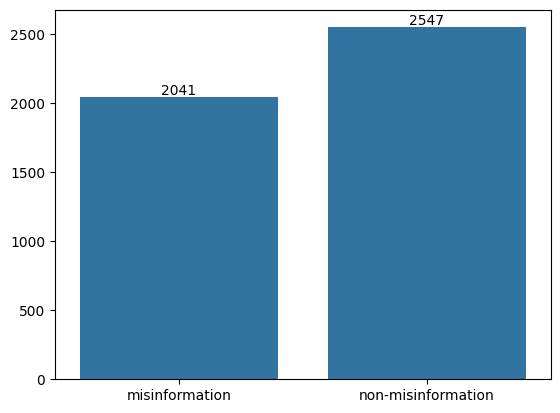

In [91]:
print('data after remove duplicates')
pos_mask = y == 1
pos = y[pos_mask]
neg_mask = y == 0
neg = y[neg_mask]
values = [pos.shape[0],neg.shape[0]]
keys = ['misinformation', 'non-misinformation']
g = sns.barplot(x = keys, y = values)
for p in g.patches:
    g.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2.,
                                               p.get_height()), ha = 'center',
               va = 'center', xytext = (0, 5), textcoords = 'offset points')

- Lenght of the data used

In [92]:
print(len(texts))
print(len(y))

4588
4588


- Misinformation column statistics

In [93]:
df.columns

Index(['id', 'date', 'hour', 'timestamp', 'ddi', 'country', 'country_iso3',
       'ddd', 'state', 'group', 'midia', 'url', 'characters', 'words', 'types',
       'viral', 'shares', 'text', 'misinformation'],
      dtype='object')

In [94]:
def avgSizeWords(string):
     list_string = string.split()
     chars = np.array([len(s) for s in list_string])
     return chars.mean()
df['types'] = [len(set(t.split())) for t in df['text']]
df['types/token ratio'] = df['types']/df['words']
df['char/word ratio'] = df['characters']/df['words']
df['average chars by word'] = [avgSizeWords(t) for t in df['text']]

In [95]:
mis = df[df['misinformation']==1][['words','types','types/token ratio' ,'characters', 'char/word ratio', 'average chars by word','shares']].mean().to_frame().rename(columns={0: "misinformation"})
non_mis = df[df['misinformation']==0][['words','types','types/token ratio' ,'characters', 'char/word ratio', 'average chars by word','shares']].mean().to_frame().rename(columns={0: "non-misinformation"})
mis.join(non_mis, lsuffix='_misinformation', rsuffix='_non-misinformation')

,misinformation,non-misinformation
words,113.870652,60.044366
types,78.719255,44.574401
types/token ratio,0.845943,0.899166
characters,719.406663,408.918728
char/word ratio,6.590809,7.231410
average chars by word,5.529126,6.174667
shares,4.974032,3.454653


- Train/Test split

- Pre-processing

In [96]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/miguelmauricioantonio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [97]:
# !python -m spacy download pt_core_news_sm

In [98]:
#emojis and punctuation
emojis_list = list(emoji.EMOJI_DATA.keys())
emojis_list += ['\n']
punct = list(string.punctuation) + ['\n']
emojis_punct = emojis_list + punct

def processEmojisPunctuation(text, remove_punct = False, remove_emoji = False):
    '''
    Put spaces between emojis. Removes punctuation.
    '''
    #get all unique chars
    chars = set(text)
    #for each unique char in text, do:
    for c in chars:

        if remove_punct: #remove punctuation
            if c in punct:
                text = text.replace(c, ' ')
        else: #put spaces between punctuation
            if c in punct:
                text = text.replace(c, ' ' + c + ' ')

        if remove_emoji: #remove emojis
            if c in emojis_list:
                text = text.replace(c, ' ')
        else: #put spaces between emojis
            if c in emojis_list:
                text = text.replace(c, ' ' + c + ' ')

    text = re.sub(' +', ' ', text)
    return text

#stop words removal
stop_words = list(stopwords.words('portuguese'))
new_stopwords = ['aí','pra','vão','vou','onde','lá','aqui',
                 'tá','pode','pois','so','deu','agora','todo',
                 'nao','ja','vc', 'bom', 'ai','ta', 'voce', 'alguem', 'ne', 'pq',
                 'cara','to','mim','la','vcs','tbm', 'tudo']
stop_words = stop_words + new_stopwords
final_stop_words = []
for sw in stop_words:
    sw = ' '+ sw + ' '
    final_stop_words.append(sw)

def removeStopwords(text):
    for sw in final_stop_words:
        text = text.replace(sw,' ')
    text = re.sub(' +',' ',text)
    return text

#lemmatization
nlp = spacy.load('pt_core_news_sm')
def lemmatization(text):
    doc = nlp(text)
    for token in doc:
        if token.text != token.lemma_:
            text = text.replace(token.text, token.lemma_)
    return text


def domainUrl(text):
    '''
    Substitutes an URL in a text for the domain of this URL
    Input: an string
    Output: the string with the modified URL
    '''
    if 'http' in text:
        re_url = '[^\s]*https*://[^\s]*'
        matches = re.findall(re_url, text, flags=re.IGNORECASE)
        for m in matches:
            domain = m.split('//')
            domain = domain[1].split('/')[0]
            text = re.sub(re_url, domain, text, 1)
        return text
    else:
        return text

def processLoL(text):
    re_kkk = 'kkk*'
    t = re.sub(re_kkk, "kkk", text, flags=re.IGNORECASE)
    return t

def firstSentence(text):
    list_s = re.split('; |\. |\! |\? |\n',text)
    for s in list_s:
        if s is not None:
            return s


def preprocess(text,semi=False, rpunct = False, remoji = False, sentence = False):
    if sentence:
        text = firstSentence(text) # remove
    text = text.lower().strip()
    text = domainUrl(text)
    text = processLoL(text)
    text = processEmojisPunctuation(text,remove_punct = rpunct, remove_emoji=remoji)
    if semi:
        return text
    text = removeStopwords(text)
    text = lemmatization(text)
    return text


<>:68: SyntaxWarning: invalid escape sequence '\s'
<>:84: SyntaxWarning: invalid escape sequence '\.'
<>:68: SyntaxWarning: invalid escape sequence '\s'
<>:84: SyntaxWarning: invalid escape sequence '\.'
/var/folders/jc/ggdhgrys23xgcrxc0fly4jjc0000gn/T/ipykernel_1471/1358206803.py:68: SyntaxWarning: invalid escape sequence '\s'
  re_url = '[^\s]*https*://[^\s]*'
/var/folders/jc/ggdhgrys23xgcrxc0fly4jjc0000gn/T/ipykernel_1471/1358206803.py:84: SyntaxWarning: invalid escape sequence '\.'
  list_s = re.split('; |\. |\! |\? |\n',text)


In [99]:
texts = df['pre_processed_text'] = [preprocess(t, sentence = True) for t in texts]

/var/folders/jc/ggdhgrys23xgcrxc0fly4jjc0000gn/T/ipykernel_1471/1358206803.py:73: DeprecationWarning: 'count' is passed as positional argument
  text = re.sub(re_url, domain, text, 1)


In [100]:
texts_train, texts_test, y_train, y_test = train_test_split(texts,y,test_size=0.2,stratify=y,random_state=42)

- Only retain one hundred words for each text

In [101]:
def trucateText(text):
    words = text.split()
    if len(words) <= 100:
        return text
    else:
        words = words[0:100]
        text = ' '.join(words)
        return text

In [102]:
texts = [trucateText(t) for t in texts]

- Vectorization

In [103]:
vectorization = ['tfidf-']
ngrams = ['unigram_bigram_trigram']
processed = ['-pre_processed']
max_features = ['']#,'-max_features']
balancing = ['-oversampling']
experiments = []

for vec in vectorization:
    for ng in ngrams:
        for p in processed:
            for m in max_features:
                exp = vec+ng+p+m
                experiments.append(exp)

print(len(experiments))
experiments


1


['tfidf-unigram_bigram_trigram-pre_processed']

In [104]:
def defineVectorizing(experiment):
    max_feat = None
    # maximum number of features
    if 'max_features' in experiment:
        max_feat = 5000
    exp_parts = experiment.split('-')
    vec = exp_parts[0]
    ngram = exp_parts[1]
    # ngram
    if ngram == 'unigram':
        ng = (1,1)
    elif ngram == 'unigram_bigram':
        ng = (1,2)
    elif ngram == 'unigram_bigram_trigram':
        ng = (1,3)
    # vectorizer
    if vec == 'bow':
        vectorizer = CountVectorizer(max_features = max_feat, binary=True, ngram_range = ng, lowercase = False, token_pattern = r'[^\s]+')
    elif vec == 'tfidf':
        vectorizer = TfidfVectorizer(max_features = max_feat, ngram_range = ng, lowercase = False, token_pattern = r'[^\s]+')

    return vectorizer

def vectorizing(vectorizer,texts_train,texts_test):
    vectorizer.fit(texts_train) # learns the vocabulary
    X_train = vectorizer.transform(texts_train) # converts new text into vectors using the learning vocabulary
    X_test = vectorizer.transform(texts_test)
    #print('Train:',X_train.shape)
    #print('Test:',X_test.shape)
    return X_train, X_test

vectorizer = defineVectorizing(experiments[0])
X_train,X_test = vectorizing(vectorizer,texts_train,texts_test)

- Models Train and Test

In [105]:
models = ['lr','nb','lsvm','sgd', 'svm', 'knn', 'rf', 'gb', 'mlp']
print(len(models))
models

9


['lr', 'nb', 'lsvm', 'sgd', 'svm', 'knn', 'rf', 'gb', 'mlp']

In [106]:
def getTestMetrics(y_true, y_pred, y_prob=None, full_metrics=False):
    from sklearn.metrics import (
        accuracy_score as sk_accuracy,
        precision_score as sk_precision,
        recall_score as sk_recall,
        f1_score as sk_f1,
        roc_auc_score as sk_roc_auc
    )

    acc = sk_accuracy(y_true, y_pred)
    precision = sk_precision(y_true, y_pred, average='macro')
    recall = sk_recall(y_true, y_pred, average='macro')
    f1 = sk_f1(y_true, y_pred, average='macro')

    try:
        roc_auc = sk_roc_auc(y_true, y_prob, multi_class='ovr')
    except Exception:
        roc_auc = np.nan

    # placeholders para compatibilidade
    precision_neg = recall_neg = f1_neg = np.nan

    if full_metrics:
        print(f"Accuracy: {acc:.3f}")
        print(f"Precision (macro): {precision:.3f}")
        print(f"Recall (macro): {recall:.3f}")
        print(f"F1 (macro): {f1:.3f}")
        print(f"AUC: {roc_auc:.3f}")

    return acc, precision, precision_neg, recall, recall_neg, f1, f1_neg, roc_auc


In [107]:
def lr_eval(X_train, y_train, X_test, y_test):
    print('=== Logistic Regression ===')
    logreg = LogisticRegression().fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    y_prob = logreg.predict_proba(X_test)[:, 1]
    metrics = getTestMetrics(y_test, y_pred, y_prob, full_metrics=True)
    return logreg, metrics


def nb_eval(X_train, y_train, X_test, y_test):
    if 'bow' in experiments[0]:
        print('=== Bernoulli Naive-Bayes ===')
        nb = BernoulliNB().fit(X_train, y_train)
    elif 'tfidf' in experiments[0]:
        print('=== Complement Naive-Bayes ===')
        nb = ComplementNB().fit(X_train, y_train)
    else:
        nb = BernoulliNB().fit(X_train, y_train)
    y_pred = nb.predict(X_test)
    y_prob = nb.predict_proba(X_test)[:, 1]
    metrics = getTestMetrics(y_test, y_pred, y_prob, full_metrics=True)
    return nb, metrics


def lsvm_eval(X_train, y_train, X_test, y_test):
    print('=== Linear Support Vector Machine ===')
    svm = LinearSVC(dual=False).fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    metrics = getTestMetrics(y_test, y_pred, full_metrics=True)
    return svm, metrics


def sgd_eval(X_train, y_train, X_test, y_test):
    print('=== Linear SVM with SGD training ===')
    sgd = SGDClassifier().fit(X_train, y_train)
    y_pred = sgd.predict(X_test)
    metrics = getTestMetrics(y_test, y_pred, full_metrics=True)
    return sgd, metrics


def svm_eval(X_train, y_train, X_test, y_test):
    print('=== SVM with RBF kernel ===')
    svc = SVC(probability=True).fit(X_train, y_train)
    y_pred = svc.predict(X_test)
    y_prob = svc.predict_proba(X_test)[:, 1]
    metrics = getTestMetrics(y_test, y_pred, y_prob, full_metrics=True)
    return svc, metrics


def knn_eval(X_train, y_train, X_test, y_test):
    print('=== KNN ===')
    knn = KNeighborsClassifier(weights='distance', n_jobs=-1).fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    y_prob = knn.predict_proba(X_test)[:, 1]
    metrics = getTestMetrics(y_test, y_pred, y_prob, full_metrics=True)
    return knn, metrics


def rf_eval(X_train, y_train, X_test, y_test):
    print('=== Random Forest ===')
    rf = RandomForestClassifier(n_jobs=-1).fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    y_prob = rf.predict_proba(X_test)[:, 1]
    metrics = getTestMetrics(y_test, y_pred, y_prob, full_metrics=True)
    return rf, metrics


def gb_eval(X_train, y_train, X_test, y_test):
    print('=== Gradient Boosting ===')
    gb = GradientBoostingClassifier(n_estimators=200).fit(X_train, y_train)
    y_pred = gb.predict(X_test)
    y_prob = gb.predict_proba(X_test)[:, 1]
    metrics = getTestMetrics(y_test, y_pred, y_prob, full_metrics=True)
    return gb, metrics


def mlp_eval(X_train, y_train, X_test, y_test):
    print('=== Multilayer Perceptron ===')
    mlp = MLPClassifier(
        verbose=True, early_stopping=True,
        batch_size=64, n_iter_no_change=5, tol=1e-3
    ).fit(X_train, y_train)
    y_pred = mlp.predict(X_test)
    y_prob = mlp.predict_proba(X_test)[:, 1]
    metrics = getTestMetrics(y_test, y_pred, y_prob, full_metrics=True)
    return mlp, metrics


def model_eval(model, X_train, y_train, X_test, y_test):
    if model == 'lr':
        return lr_eval(X_train, y_train, X_test, y_test)
    elif model == 'nb':
        return nb_eval(X_train, y_train, X_test, y_test)
    elif model == 'lsvm':
        return lsvm_eval(X_train, y_train, X_test, y_test)
    elif model == 'sgd':
        return sgd_eval(X_train, y_train, X_test, y_test)
    elif model == 'svm':
        return svm_eval(X_train, y_train, X_test, y_test)
    elif model == 'knn':
        return knn_eval(X_train, y_train, X_test, y_test)
    elif model == 'rf':
        return rf_eval(X_train, y_train, X_test, y_test)
    elif model == 'gb':
        return gb_eval(X_train, y_train, X_test, y_test)
    elif model == 'mlp':
        return mlp_eval(X_train, y_train, X_test, y_test)
    else:
        raise ValueError(f"Model '{model}' unknown.")

In [108]:
lr = model_eval('lr',X_train,y_train,X_test,y_test)
nb = model_eval('nb',X_train,y_train,X_test,y_test)
lsvm = model_eval('lsvm',X_train,y_train,X_test,y_test)
sgd = model_eval('sgd',X_train,y_train,X_test,y_test)
knn = model_eval('knn',X_train,y_train,X_test,y_test)
rf = model_eval('rf',X_train,y_train,X_test,y_test)
gb = model_eval('gb',X_train,y_train,X_test,y_test)
mlp = model_eval('mlp',X_train,y_train,X_test,y_test)

=== Logistic Regression ===
Accuracy: 0.687
Precision (macro): 0.684
Recall (macro): 0.677
F1 (macro): 0.678
AUC: 0.748
=== Complement Naive-Bayes ===
Accuracy: 0.715
Precision (macro): 0.711
Recall (macro): 0.709
F1 (macro): 0.709
AUC: 0.783
=== Linear Support Vector Machine ===
Accuracy: 0.700
Precision (macro): 0.697
Recall (macro): 0.698
F1 (macro): 0.698
AUC: nan
=== Linear SVM with SGD training ===
Accuracy: 0.694
Precision (macro): 0.692
Recall (macro): 0.694
F1 (macro): 0.692
AUC: nan
=== KNN ===
Accuracy: 0.647
Precision (macro): 0.667
Recall (macro): 0.661
F1 (macro): 0.646
AUC: 0.725
=== Random Forest ===
Accuracy: 0.658
Precision (macro): 0.653
Recall (macro): 0.653
F1 (macro): 0.653
AUC: 0.723
=== Gradient Boosting ===
Accuracy: 0.599
Precision (macro): 0.591
Recall (macro): 0.583
F1 (macro): 0.581
AUC: 0.641
=== Multilayer Perceptron ===
Iteration 1, loss = 0.67207129
Validation score: 0.629428
Iteration 2, loss = 0.51348328
Validation score: 0.694823
Iteration 3, loss = 

In [109]:
print(lr[0])
print(lr[1])

LogisticRegression()
(0.6873638344226579, 0.6841100076394193, nan, 0.6772058823529412, nan, 0.6784313725490196, nan, 0.7478806228373702)


# Experiences

## Experience 1 - Generating LIME explanations for each model predictions and compared the words that appear the most

LIME object stores: weights, class probabilities, raw scores, and links back to the original text.

In [110]:
def explain_with_lime(model,vectorizer,texts,idx):
    explainer = LimeTextExplainer(class_names=["real","fake"])

    if hasattr(texts,"iloc"):
      text_instance = texts.iloc[idx]
    else:
      text_instance = texts[idx]

    def predict_proba(texts_list):
        X = vectorizer.transform(texts_list)
        if hasattr(model, "predict_proba"):
            return model.predict_proba(X)
        else:
            scores = model.decision_function(X)
            if scores.ndim == 1:
                scores = np.vstack([-scores, scores]).T
            probs = np.exp(scores) / np.exp(scores).sum(axis=1, keepdims=True)  # converts into pseudo-prob.
            return probs

    print(f"\nText: {text_instance}")
    print("Predicted Class:", model.predict(vectorizer.transform([text_instance]))[0])
    exp = explainer.explain_instance(text_instance, predict_proba, num_features=10)
    exp.show_in_notebook(text=True)
    return exp


trained_models = {
    "LogisticRegression": lr,
    "MultinomialNB": nb,
    "LinearSVC": lsvm,
    "SGDClassifier": sgd,
    "KNN": knn,
    "RandomForest": rf,
    "GradientBoosting": gb,
    "MLP": mlp
}

idx = 200
for name, model_tuple in trained_models.items():
    print(f"\nModel: {name}")
    try:
        model = model_tuple[0] if isinstance(model_tuple, tuple) else model_tuple
        exp = explain_with_lime(model,vectorizer,texts_test,idx)
    except Exception as e:
        print(f"Error with {name}: {e}")



Model: LogisticRegression

Text: liguei diretório pt ofercer ajuda . . . . . 
Predicted Class: 1
Error with LogisticRegression: cannot import name 'display' from 'IPython.core.display' (/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/IPython/core/display.py)

Model: MultinomialNB

Text: liguei diretório pt ofercer ajuda . . . . . 
Predicted Class: 1
Error with MultinomialNB: cannot import name 'display' from 'IPython.core.display' (/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/IPython/core/display.py)

Model: LinearSVC

Text: liguei diretório pt ofercer ajuda . . . . . 
Predicted Class: 1
Error with LinearSVC: cannot import name 'display' from 'IPython.core.display' (/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/IPython/core/display.py)

Model: SGDClassifier

Text: liguei diretório pt ofercer ajuda . . . . . 
Predicted Class: 1
Error with SGDClassifier: cannot import name 'display' from

In [111]:
trained_models.items()

dict_items([('LogisticRegression', (LogisticRegression(), (0.6873638344226579, 0.6841100076394193, nan, 0.6772058823529412, nan, 0.6784313725490196, nan, 0.7478806228373702))), ('MultinomialNB', (ComplementNB(), (0.7145969498910676, 0.7110532970239253, nan, 0.708578431372549, nan, 0.7094655972168535, nan, 0.7831699346405229))), ('LinearSVC', (LinearSVC(dual=False), (0.7004357298474946, 0.6971878778609901, nan, 0.6982843137254902, nan, 0.6975933244130651, nan, nan))), ('SGDClassifier', (SGDClassifier(), (0.6938997821350763, 0.6920164292131947, nan, 0.6941176470588235, nan, 0.6921606323906903, nan, nan))), ('KNN', (KNeighborsClassifier(n_jobs=-1, weights='distance'), (0.6470588235294118, 0.6668010752688172, nan, 0.6610294117647059, nan, 0.6460912400942387, nan, 0.7247332756632064))), ('RandomForest', (RandomForestClassifier(n_jobs=-1), (0.6579520697167756, 0.6534189517528636, nan, 0.6529411764705881, nan, 0.6531513970110461, nan, 0.722822952710496))), ('GradientBoosting', (GradientBoosti

In [112]:
# return the common words between models and show the word weight
def compare_lime_words(trained_models,vectorizer,texts,idx):

    words_by_model = {} # {word1:[(model1],"fake",weight1),(model2,"fake",weight2)}

    for name, model_tuple in trained_models.items():
        try:
            if isinstance(model_tuple,tuple):
              model = model_tuple[0]
            else:
              model = model_tuple
            exp = explain_with_lime(model,vectorizer,texts,idx)
            words = exp.as_list() # return a [(word1,weight1),(word2,weight2),...]

            for w,weight in words:
              # fake is 1 and real is 0
              if weight > 0:
                assign = "fake"
              else:
                assign = "real"
              if w not in words_by_model:
                words_by_model[w] = []
              words_by_model[w].append((name,assign,abs(weight)))

        except Exception:
            pass

    # to keep only the words that are on multiple models
    shared_words = {}
    for w,info in words_by_model.items():
      if len(info) > 1:
        shared_words[w] = info

    if not shared_words:
        return pd.DataFrame(columns=["word","avg_weight"])

    rows = []
    for word,infos in shared_words.items():
        avg_weight = np.mean([x[2] for x in infos])
        directions = {x[0]: x[1] for x in infos}  # builds the direction of the word (fake or real)
        rows.append({"word":word, "avg_weight":avg_weight, **directions})

    df = pd.DataFrame(rows).sort_values("avg_weight", ascending=False).fillna("-")
    return df


idx = 200  # sentence that will be analyzed
df_common = compare_lime_words(trained_models,vectorizer,texts_test,idx)
df_common



Text: liguei diretório pt ofercer ajuda . . . . . 
Predicted Class: 1

Text: liguei diretório pt ofercer ajuda . . . . . 
Predicted Class: 1

Text: liguei diretório pt ofercer ajuda . . . . . 
Predicted Class: 1

Text: liguei diretório pt ofercer ajuda . . . . . 
Predicted Class: 1

Text: liguei diretório pt ofercer ajuda . . . . . 
Predicted Class: 1

Text: liguei diretório pt ofercer ajuda . . . . . 
Predicted Class: 1

Text: liguei diretório pt ofercer ajuda . . . . . 
Predicted Class: 1

Text: liguei diretório pt ofercer ajuda . . . . . 
Predicted Class: 1


,word,avg_weight


## Experience 2 - Global Approach


Generating LIME explanations for: LogisticRegression


 19%|█▊        | 56/300 [00:02<00:08, 28.00it/s]

Error on LogisticRegression in sample 52: low >= high


 23%|██▎       | 70/300 [00:02<00:08, 28.04it/s]

Error on LogisticRegression in sample 65: low >= high


 33%|███▎      | 98/300 [00:03<00:07, 25.87it/s]

Error on LogisticRegression in sample 92: low >= high


 67%|██████▋   | 201/300 [00:08<00:04, 24.55it/s]

Error on LogisticRegression in sample 196: low >= high


 94%|█████████▍| 283/300 [00:12<00:00, 26.29it/s]

Error on LogisticRegression in sample 279: low >= high


 97%|█████████▋| 290/300 [00:12<00:00, 27.46it/s]

Error on LogisticRegression in sample 286: low >= high


100%|██████████| 300/300 [00:12<00:00, 23.34it/s]



Generating LIME explanations for: MultinomialNB


 18%|█▊        | 55/300 [00:02<00:09, 26.69it/s]

Error on MultinomialNB in sample 52: low >= high


 23%|██▎       | 69/300 [00:02<00:08, 28.37it/s]

Error on MultinomialNB in sample 65: low >= high


 32%|███▏      | 96/300 [00:03<00:08, 25.49it/s]

Error on MultinomialNB in sample 92: low >= high


 67%|██████▋   | 200/300 [00:08<00:04, 24.65it/s]

Error on MultinomialNB in sample 196: low >= high


 95%|█████████▍| 284/300 [00:12<00:00, 26.11it/s]

Error on MultinomialNB in sample 279: low >= high


 97%|█████████▋| 291/300 [00:12<00:00, 26.21it/s]

Error on MultinomialNB in sample 286: low >= high


100%|██████████| 300/300 [00:12<00:00, 23.35it/s]



Generating LIME explanations for: LinearSVC


 19%|█▉        | 58/300 [00:02<00:09, 26.31it/s]

Error on LinearSVC in sample 52: low >= high


 23%|██▎       | 69/300 [00:02<00:08, 28.77it/s]

Error on LinearSVC in sample 65: low >= high


 32%|███▏      | 96/300 [00:03<00:08, 25.24it/s]

Error on LinearSVC in sample 92: low >= high


 67%|██████▋   | 201/300 [00:08<00:03, 25.10it/s]

Error on LinearSVC in sample 196: low >= high


 94%|█████████▍| 283/300 [00:12<00:00, 26.72it/s]

Error on LinearSVC in sample 279: low >= high


 97%|█████████▋| 290/300 [00:12<00:00, 28.04it/s]

Error on LinearSVC in sample 286: low >= high


100%|██████████| 300/300 [00:12<00:00, 23.57it/s]



Generating LIME explanations for: SGDClassifier


 19%|█▊        | 56/300 [00:02<00:08, 27.81it/s]

Error on SGDClassifier in sample 52: low >= high


 23%|██▎       | 70/300 [00:02<00:08, 28.55it/s]

Error on SGDClassifier in sample 65: low >= high


 33%|███▎      | 98/300 [00:03<00:07, 26.18it/s]

Error on SGDClassifier in sample 92: low >= high


 67%|██████▋   | 201/300 [00:08<00:03, 24.84it/s]

Error on SGDClassifier in sample 196: low >= high


 94%|█████████▍| 283/300 [00:12<00:00, 27.05it/s]

Error on SGDClassifier in sample 279: low >= high


 96%|█████████▌| 288/300 [00:12<00:00, 29.83it/s]

Error on SGDClassifier in sample 286: low >= high


100%|██████████| 300/300 [00:12<00:00, 23.66it/s]



Generating LIME explanations for: KNN


 18%|█▊        | 54/300 [00:06<00:22, 10.82it/s]

Error on KNN in sample 52: low >= high


 22%|██▏       | 67/300 [00:08<00:23,  9.83it/s]

Error on KNN in sample 65: low >= high


 31%|███▏      | 94/300 [00:12<00:20, 10.21it/s]

Error on KNN in sample 92: low >= high


 66%|██████▌   | 198/300 [00:26<00:11,  9.25it/s]

Error on KNN in sample 196: low >= high


 94%|█████████▎| 281/300 [00:38<00:01, 10.11it/s]

Error on KNN in sample 279: low >= high


 96%|█████████▌| 288/300 [00:38<00:01,  9.76it/s]

Error on KNN in sample 286: low >= high


100%|██████████| 300/300 [00:40<00:00,  7.37it/s]



Generating LIME explanations for: RandomForest


 18%|█▊        | 55/300 [00:04<00:17, 13.72it/s]

Error on RandomForest in sample 52: low >= high


 23%|██▎       | 68/300 [00:05<00:15, 15.32it/s]

Error on RandomForest in sample 65: low >= high


 32%|███▏      | 95/300 [00:07<00:13, 15.02it/s]

Error on RandomForest in sample 92: low >= high


 66%|██████▌   | 198/300 [00:15<00:06, 15.10it/s]

Error on RandomForest in sample 196: low >= high


 94%|█████████▍| 283/300 [00:22<00:01, 15.27it/s]

Error on RandomForest in sample 279: low >= high


 96%|█████████▌| 288/300 [00:22<00:00, 15.33it/s]

Error on RandomForest in sample 286: low >= high


100%|██████████| 300/300 [00:23<00:00, 12.80it/s]



Generating LIME explanations for: GradientBoosting


 19%|█▉        | 58/300 [00:02<00:09, 24.21it/s]

Error on GradientBoosting in sample 52: low >= high


 24%|██▎       | 71/300 [00:03<00:09, 25.34it/s]

Error on GradientBoosting in sample 65: low >= high


 32%|███▏      | 96/300 [00:04<00:08, 24.05it/s]

Error on GradientBoosting in sample 92: low >= high


 66%|██████▋   | 199/300 [00:09<00:04, 23.51it/s]

Error on GradientBoosting in sample 196: low >= high


 95%|█████████▍| 284/300 [00:13<00:00, 23.99it/s]

Error on GradientBoosting in sample 279: low >= high


 97%|█████████▋| 291/300 [00:13<00:00, 24.44it/s]

Error on GradientBoosting in sample 286: low >= high


100%|██████████| 300/300 [00:13<00:00, 21.56it/s]



Generating LIME explanations for: MLP


 19%|█▊        | 56/300 [00:02<00:08, 27.51it/s]

Error on MLP in sample 52: low >= high


 23%|██▎       | 70/300 [00:02<00:08, 27.91it/s]

Error on MLP in sample 65: low >= high


 33%|███▎      | 98/300 [00:04<00:07, 25.39it/s]

Error on MLP in sample 92: low >= high


 67%|██████▋   | 201/300 [00:08<00:04, 24.42it/s]

Error on MLP in sample 196: low >= high


 94%|█████████▍| 283/300 [00:12<00:00, 26.26it/s]

Error on MLP in sample 279: low >= high


 97%|█████████▋| 290/300 [00:12<00:00, 27.21it/s]

Error on MLP in sample 286: low >= high


100%|██████████| 300/300 [00:12<00:00, 23.12it/s]



LIME results saved.


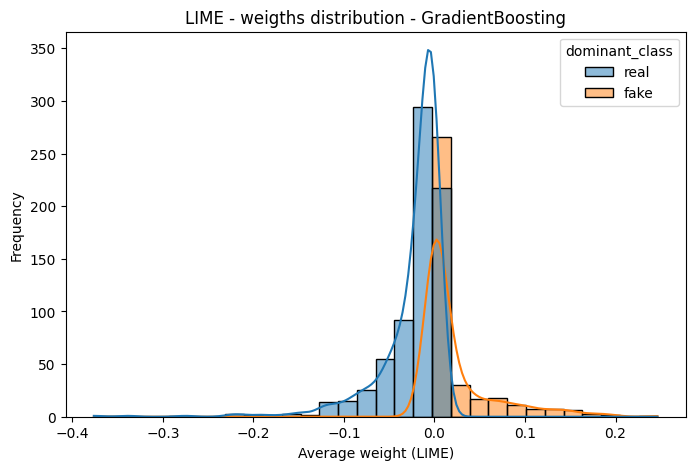


Top 10 most explicative words for Fake (GradientBoosting)


,word,avg_weight,n_occurrences
727,padre,0.246324,1
6,1,0.197596,5
988,tentar,0.188115,1
852,publicar,0.181698,2
647,mil,0.179134,1
199,bolsonariano,0.169457,1
549,igreja,0.161544,2
1047,ver,0.150969,8
517,governo,0.150231,3
711,olher,0.149549,1



Top 10 most explicative words for REAL (GradientBoosting)


,word,avg_weight,n_occurrences
1079,whatsapp,-0.376162,10
715,opinionstage,-0.338813,1
483,final,-0.275101,1
418,erroddod,-0.225242,1
642,mentira,-0.216826,1
550,imagem,-0.216794,1
459,facebook,-0.193867,4
995,tocantim,-0.190935,2
678,net,-0.172245,1
279,componho,-0.160019,2


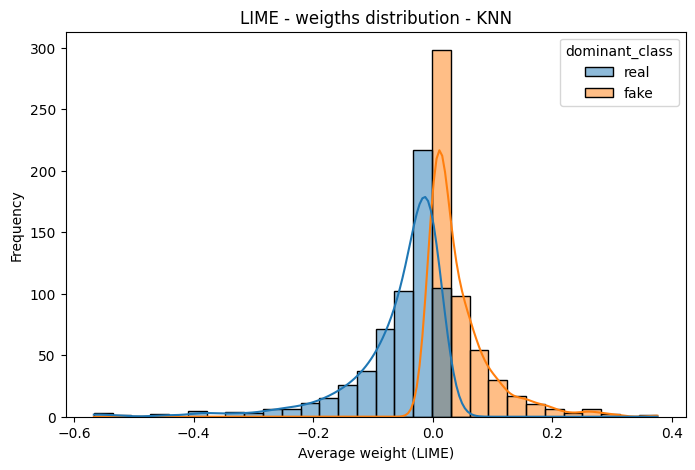


Top 10 most explicative words for Fake (KNN)


,word,avg_weight,n_occurrences
1195,achar,0.376163,1
1261,atacar,0.306716,1
1814,não,0.294417,1
2176,valer,0.279557,1
1597,focodo,0.271400,1
1827,olher,0.265957,1
1890,pena,0.254029,1
1828,onlinar,0.253935,1
1102,10,0.253074,1
1822,oficial,0.223474,3



Top 10 most explicative words for REAL (KNN)


,word,avg_weight,n_occurrences
2008,recebi,-0.567272,1
1818,oantagonista,-0.565753,4
1733,m,-0.560864,2
1919,poder360,-0.524529,1
1877,pautanoticia,-0.446072,2
2168,uol,-0.442050,2
2089,site,-0.390210,1
1540,estadao,-0.387094,1
2219,whatsapp,-0.385926,12
1348,chat,-0.384640,9


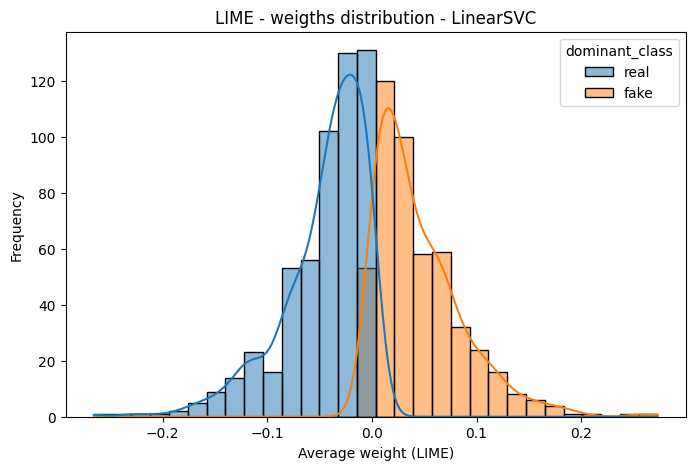


Top 10 most explicative words for Fake (LinearSVC)


,word,avg_weight,n_occurrences
2914,opinionstage,0.272956,1
2236,03,0.252665,1
2981,petista,0.201986,5
3048,publicar,0.190288,2
3086,repassar,0.182420,1
2869,mst,0.180305,1
2321,absurdo,0.175682,2
2918,ordeste,0.173374,1
2910,olher,0.162887,1
3228,ver,0.161357,10



Top 10 most explicative words for REAL (LinearSVC)


,word,avg_weight,n_occurrences
2902,oantagonista,-0.265782,4
3177,tocantim,-0.232673,2
2908,oi,-0.215048,2
3253,whatsapp,-0.194770,12
3071,recebi,-0.181864,1
2988,plantaogospel,-0.178868,1
2833,marina,-0.169326,1
2605,e,-0.166017,3
3116,satisfeito,-0.165951,1
2451,carreato,-0.164642,1


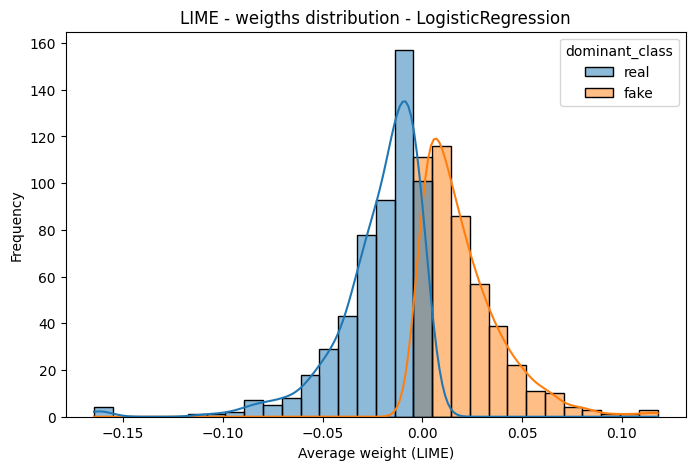


Top 10 most explicative words for Fake (LogisticRegression)


,word,avg_weight,n_occurrences
3264,03,0.117853,1
3930,opinionstage,0.117510,1
4061,publicar,0.109617,2
3995,petista,0.101121,5
4238,ver,0.093045,10
3927,onlinar,0.083231,1
4268,áudio,0.083086,1
3349,absurdo,0.082590,2
3284,27,0.076624,1
3518,compartilhem,0.076320,4



Top 10 most explicative words for REAL (LogisticRegression)


,word,avg_weight,n_occurrences
4002,plantaogospel,-0.164556,1
4189,tocantim,-0.161727,2
4262,whatsapp,-0.160718,13
3917,oantagonista,-0.160521,4
3924,oi,-0.110272,2
3455,br,-0.102234,11
4129,satisfeito,-0.095671,1
4005,poder360,-0.092040,1
3595,dia,-0.087643,10
3348,abril,-0.087337,1


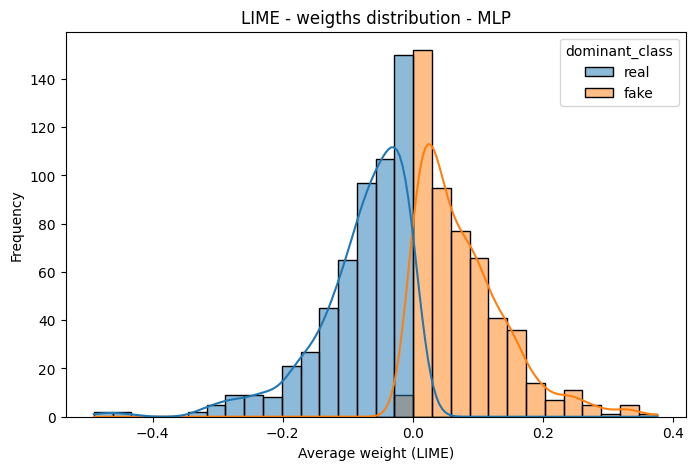


Top 10 most explicative words for Fake (MLP)


,word,avg_weight,n_occurrences
4983,ordeste,0.376137,1
5148,registrar,0.334968,3
4930,mst,0.334604,1
4952,noite,0.328516,1
4842,janeirer,0.327222,2
4979,opinionstage,0.318670,1
4437,atacar,0.292456,1
4907,mentira,0.283807,1
5332,x,0.280548,1
5154,repassar,0.276176,1



Top 10 most explicative words for REAL (MLP)


,word,avg_weight,n_occurrences
4966,oantagonista,-0.490182,4
4714,exame,-0.468073,1
5056,poder360,-0.458577,1
4947,net,-0.436825,1
5185,satisfeito,-0.323336,1
4724,facebook,-0.320869,2
5139,recebi,-0.314777,1
5016,passo,-0.312722,1
4972,oi,-0.303877,2
4902,meme,-0.302365,1


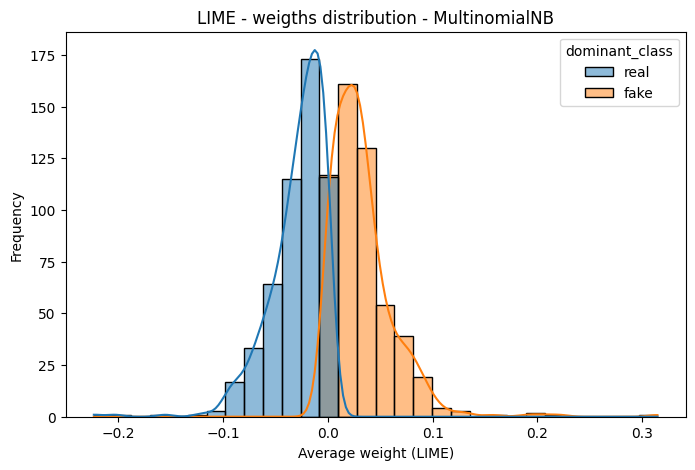


Top 10 most explicative words for Fake (MultinomialNB)


,word,avg_weight,n_occurrences
6046,opinionstage,0.314485,1
5344,03,0.221195,1
6043,onlinar,0.204963,1
6177,publicar,0.190226,2
5365,27,0.157256,1
6212,registrar,0.131901,3
5977,mentira,0.129552,1
5436,absurdo,0.120304,2
6042,olher,0.108789,1
5998,mst,0.107873,1



Top 10 most explicative words for REAL (MultinomialNB)


,word,avg_weight,n_occurrences
6033,oantagonista,-0.223265,4
6309,tocantim,-0.203231,2
6040,oi,-0.155163,2
6204,recebi,-0.122212,1
5574,carreato,-0.113842,1
5956,manhã,-0.101127,2
6288,super,-0.100530,1
6189,que,-0.096839,2
5887,importante,-0.096811,1
5554,br,-0.094752,11


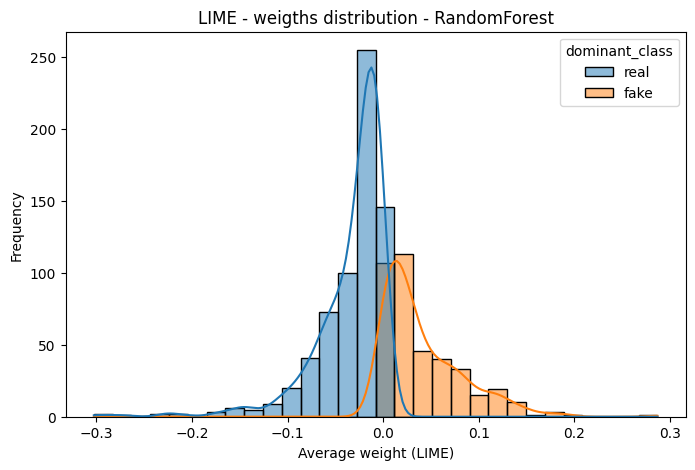


Top 10 most explicative words for Fake (RandomForest)


,word,avg_weight,n_occurrences
7229,publicar,0.286741,2
6406,1,0.190664,5
6729,deathrash,0.184878,1
6423,27,0.177265,1
7145,pena,0.172204,1
7161,petista,0.159851,5
7413,ver,0.148754,7
7156,pesquisa,0.148484,10
6402,03,0.147048,1
7348,só,0.145799,1



Top 10 most explicative words for REAL (RandomForest)


,word,avg_weight,n_occurrences
6895,gen,-0.302465,1
7440,whatsapp,-0.286671,12
6984,kkk,-0.270263,1
6642,chat,-0.229649,9
7082,oantagonista,-0.224816,4
6870,final,-0.220090,1
7365,tocantim,-0.206143,2
6939,imagem,-0.179515,1
6780,e,-0.170154,3
7028,mentira,-0.168719,1


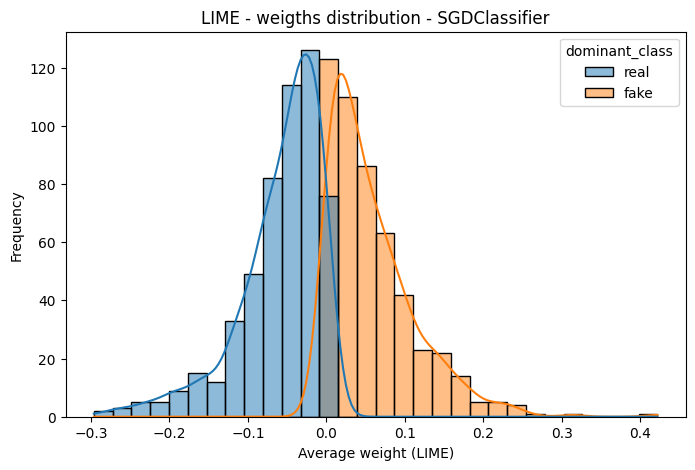


Top 10 most explicative words for Fake (SGDClassifier)


,word,avg_weight,n_occurrences
8132,opinionstage,0.421639,1
7456,03,0.313109,1
8087,mst,0.256878,1
8263,publicar,0.239467,2
8198,petista,0.234422,5
8136,ordeste,0.232051,1
8303,repar,0.230386,1
7923,fraudar,0.226581,1
7607,atacar,0.213331,1
7540,absurdo,0.211912,2



Top 10 most explicative words for REAL (SGDClassifier)


,word,avg_weight,n_occurrences
7887,facebook,-0.296340,2
8120,oantagonista,-0.275526,4
7876,exame,-0.266922,1
8126,oi,-0.262138,2
8052,marina,-0.257213,1
7820,e,-0.241334,3
8205,plantaogospel,-0.239510,1
8289,recebi,-0.232754,1
8397,tocantim,-0.229661,2
7971,hora,-0.227244,1


In [113]:
def explain_with_lime(model,vectorizer,texts,idx):
    explainer = LimeTextExplainer(class_names=["real","fake"])

    # checking if texts is a pandas series or a python list
    if hasattr(texts,"iloc"):
      text_instance = texts.iloc[idx]
    else:
      text_instance = texts[idx]

    def predict_proba(texts_list):
        X = vectorizer.transform(texts_list)  # for the texts_test
        if hasattr(model,"predict_proba"):  # checking if the model has "predict_proba" attribute
            return model.predict_proba(X)
        else:
            scores = model.decision_function(X)
            if scores.ndim == 1:
                scores = np.vstack([-scores, scores]).T
            probs = np.exp(scores) / np.exp(scores).sum(axis=1, keepdims=True)
            return probs

    exp = explainer.explain_instance(text_instance, predict_proba, num_features=10)
    return exp.as_list()  # return the list [(word,weight)]



def generate_lime_explanations(trained_models,vectorizer,texts,n_samples=300):
    results = []

    for name, model_tuple in trained_models.items():
        if isinstance(model_tuple,tuple):
          model = model_tuple[0]
        else:
          model = model_tuple

        if not hasattr(model,"predict_proba") and not hasattr(model,"decision_function"):
            print(f"{name} doesn´t support LIME (no probability or decision_function).")
            continue

        print(f"\nGenerating LIME explanations for: {name}")
        for i in tqdm(range(min(n_samples, len(texts)))):
            try:
                exp = explain_with_lime(model,vectorizer,texts,i)
                # {'model':'model_name','word':'word1','weight':weight1,'sample_idx':index,'dominant_class':'class (fake or real)'}
                for word,weight in exp:
                    results.append({
                        "model": name,
                        "word": word,
                        "weight": weight,
                        "sample_idx": i,
                        "dominant_class": "fake" if weight > 0 else "real"
                    })
            except Exception as e:
                print(f"Error on {name} in sample {i}: {e}")

    return pd.DataFrame(results)



def aggregate_word_influence(df):
    agg = (
        df.groupby(["model","word","dominant_class"])
          .agg(avg_weight=("weight","mean"),
               avg_abs_weight=("weight",lambda x: np.mean(np.abs(x))),
               n_occurrences=("weight","count"))
          .reset_index()
    )
    return agg



def plot_weight_distribution(agg_df,model_name):
    subset = agg_df[agg_df["model"] == model_name]
    plt.figure(figsize=(8,5))
    sns.histplot(data=subset, x="avg_weight", hue="dominant_class", bins=30, kde=True)
    plt.title(f"LIME - weigths distribution - {model_name}")
    plt.xlabel("Average weight (LIME)")
    plt.ylabel("Frequency")
    plt.show()


def show_top_words(agg_df,model_name,top_n=10):
    subset = agg_df[agg_df["model"] == model_name]
    top_fake = subset[subset["dominant_class"] == "fake"].nlargest(top_n, "avg_abs_weight")
    top_real = subset[subset["dominant_class"] == "real"].nlargest(top_n, "avg_abs_weight")

    print(f"\nTop {top_n} most explicative words for Fake ({model_name})")
    display(top_fake[["word", "avg_weight", "n_occurrences"]])

    print(f"\nTop {top_n} most explicative words for REAL ({model_name})")
    display(top_real[["word", "avg_weight", "n_occurrences"]])



lime_df = generate_lime_explanations(trained_models,vectorizer,texts_test,n_samples=300)
agg_df = aggregate_word_influence(lime_df)

agg_df.to_csv("lime_global_results.csv",index=False)
print("\nLIME results saved.")

for model_name in agg_df["model"].unique():
    plot_weight_distribution(agg_df,model_name)
    show_top_words(agg_df,model_name,top_n=10)


- Only for MNB,LSVM and SGD

In [114]:
best_models = ["MultinomialNB","LinearSVC","SGDClassifier"]

subset = agg_df[agg_df["model"].isin(best_models)]

for model_name in best_models:
    model_df = subset[subset["model"] == model_name]

    # Top 10 Fake words (positive weights)
    top_fake = (model_df[model_df["dominant_class"] == "fake"].nlargest(10, "avg_abs_weight"))

    # Top 10 Real words (negative weights)
    top_real = (model_df[model_df["dominant_class"] == "real"].nlargest(10, "avg_abs_weight"))

    print(f"\nModel: {model_name}")
    print("Top 10 words (FAKE):")
    display(top_fake[["word","avg_weight","n_occurrences"]])

    print("Top 10 words (REAL):")
    display(top_real[["word","avg_weight","n_occurrences"]])



Model: MultinomialNB
Top 10 words (FAKE):


,word,avg_weight,n_occurrences
6046,opinionstage,0.314485,1
5344,03,0.221195,1
6043,onlinar,0.204963,1
6177,publicar,0.190226,2
5365,27,0.157256,1
6212,registrar,0.131901,3
5977,mentira,0.129552,1
5436,absurdo,0.120304,2
6042,olher,0.108789,1
5998,mst,0.107873,1


Top 10 words (REAL):


,word,avg_weight,n_occurrences
6033,oantagonista,-0.223265,4
6309,tocantim,-0.203231,2
6040,oi,-0.155163,2
6204,recebi,-0.122212,1
5574,carreato,-0.113842,1
5956,manhã,-0.101127,2
6288,super,-0.100530,1
6189,que,-0.096839,2
5887,importante,-0.096811,1
5554,br,-0.094752,11



Model: LinearSVC
Top 10 words (FAKE):


,word,avg_weight,n_occurrences
2914,opinionstage,0.272956,1
2236,03,0.252665,1
2981,petista,0.201986,5
3048,publicar,0.190288,2
3086,repassar,0.182420,1
2869,mst,0.180305,1
2321,absurdo,0.175682,2
2918,ordeste,0.173374,1
2910,olher,0.162887,1
3228,ver,0.161357,10


Top 10 words (REAL):


,word,avg_weight,n_occurrences
2902,oantagonista,-0.265782,4
3177,tocantim,-0.232673,2
2908,oi,-0.215048,2
3253,whatsapp,-0.194770,12
3071,recebi,-0.181864,1
2988,plantaogospel,-0.178868,1
2833,marina,-0.169326,1
2605,e,-0.166017,3
3116,satisfeito,-0.165951,1
2451,carreato,-0.164642,1



Model: SGDClassifier
Top 10 words (FAKE):


,word,avg_weight,n_occurrences
8132,opinionstage,0.421639,1
7456,03,0.313109,1
8087,mst,0.256878,1
8263,publicar,0.239467,2
8198,petista,0.234422,5
8136,ordeste,0.232051,1
8303,repar,0.230386,1
7923,fraudar,0.226581,1
7607,atacar,0.213331,1
7540,absurdo,0.211912,2


Top 10 words (REAL):


,word,avg_weight,n_occurrences
7887,facebook,-0.296340,2
8120,oantagonista,-0.275526,4
7876,exame,-0.266922,1
8126,oi,-0.262138,2
8052,marina,-0.257213,1
7820,e,-0.241334,3
8205,plantaogospel,-0.239510,1
8289,recebi,-0.232754,1
8397,tocantim,-0.229661,2
7971,hora,-0.227244,1


In [115]:
best_models = ["MultinomialNB","LinearSVC","SGDClassifier"]

subset = agg_df[agg_df["model"].isin(best_models)]

top_fake_words = {}
top_real_words = {}

for model_name in best_models:
    model_df = subset[subset["model"] == model_name]

    top_fake = (
        model_df[model_df["dominant_class"] == "fake"]
        .nlargest(10, "avg_abs_weight")
    )
    top_real = (
        model_df[model_df["dominant_class"] == "real"]
        .nlargest(10, "avg_abs_weight")
    )

    top_fake_words[model_name] = set(top_fake["word"])
    top_real_words[model_name] = set(top_real["word"])

common_fake = set.intersection(*top_fake_words.values())

common_real = set.intersection(*top_real_words.values())

print("Top 10 Fake - Common Words between Models")
print(common_fake if common_fake else "No word in common.","\n")

print("Top 10 real - Common Words between Models")
print(common_real if common_real else "No word in common.")


Top 10 Fake - Common Words between Models
{np.str_('publicar'), np.str_('opinionstage'), np.str_('03'), np.str_('mst'), np.str_('absurdo')} 

Top 10 real - Common Words between Models
{np.str_('oantagonista'), np.str_('oi'), np.str_('recebi'), np.str_('tocantim')}
